# DiffusionDB prompt capture demo

## Imports

### External ibraries

In [1]:
from datasets import load_dataset
import torchvision.transforms as transforms
import json
import matplotlib.pyplot as plt
import torch
import numpy as np

### Internal classes and utility functions

In [2]:
from DecoderWithAttention import DecoderWithAttention
from Encoder import Encoder
from DiffusionDBDataLoader import DiffusionDBDataLoader
from utils import AverageMeter, clip_gradient, accuracy, adjust_learning_rate, save_checkpoint, load_checkpoint

## Demo

### Parameter setup

In [10]:
class Parameters:
    start_epoch = 0
    epochs = 1  # number of epochs to train for (if early stopping is not triggered)
    epochs_since_improvement = 0 
    batch_size = 1
    device = "cpu"
    max_img_width = 720
    max_img_height = 720

    emb_dim = 512  # dimension of word embeddings
    attention_dim = 512  # dimension of attention linear layers
    decoder_dim = 512  # dimension of decoder RNN
    dropout = 0.5

    encoder_lr = 1e-4  # learning rate for encoder if fine-tuning
    decoder_lr = 4e-4  # learning rate for decoder
    
    fine_tune_encoder = False  # fine-tune encoder?

    grad_clip = 5.  # clip gradients at an absolute value of
    alpha_c = 1.  # regularization parameter for 'doubly stochastic attention', as in the paper

    print_freq = 100  # print training/validation stats every __ batches

### Load data

In [11]:
dataset = load_dataset('poloclub/diffusiondb', '2m_first_1k')["train"]
images_dataset = dataset["image"]
prompts_dataset = dataset["prompt"]
#max_img_width = max(dataset["width"])
#max_img_height = max(dataset["height"])

Found cached dataset diffusiondb (C:/Users/46763/.cache/huggingface/datasets/poloclub___diffusiondb/2m_first_1k/0.9.1/547894e3a57aa647ead68c9faf148324098f47f2bc1ab6705d670721de9d89d1)
100%|██████████| 1/1 [00:00<00:00, 333.41it/s]


### Raw input

In [129]:
demo_index = 600

a portrait of a panther portrait, cute and adorable, pretty, beautiful, art portrait, matte fantasy painting, deviantart, super detailed eyes, super detailed, nose, super detailed, eyes, artstation, by jason felix by steve argyle by tyler jacobson by peter mohrbacher, cinematic 


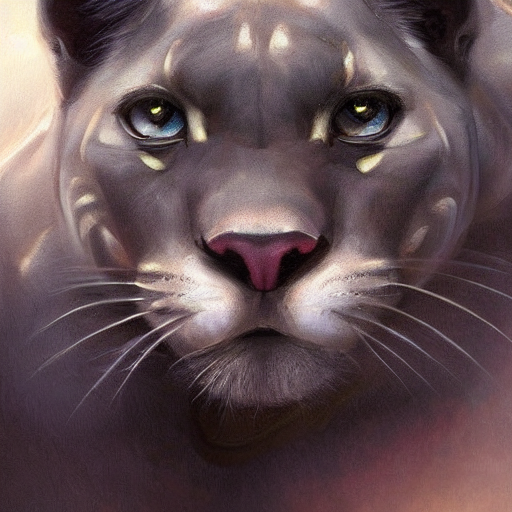

In [130]:
print(prompts_dataset[demo_index])
images_dataset[demo_index]

### Preprocessing

In [114]:
with open('word_map.json') as json_file:
    word_map_dict = json.load(json_file)

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
                                     
demo_loader = DiffusionDBDataLoader(images_dataset[demo_index:demo_index+1], 
                                    prompts_dataset[demo_index:demo_index+1], 
                                    (Parameters.max_img_width, Parameters.max_img_height),
                                    word_map_dict,
                                    Parameters.batch_size, 
                                    transform=normalize)

Assertions and dimensions
Loading prompts
Setting up transformer
Creating batches


#### Image and prompt after preprocessing

Encoded prompt: [1, 13924, 10030, 994, 33, 13924, 10031, 10032, 10033, 2]


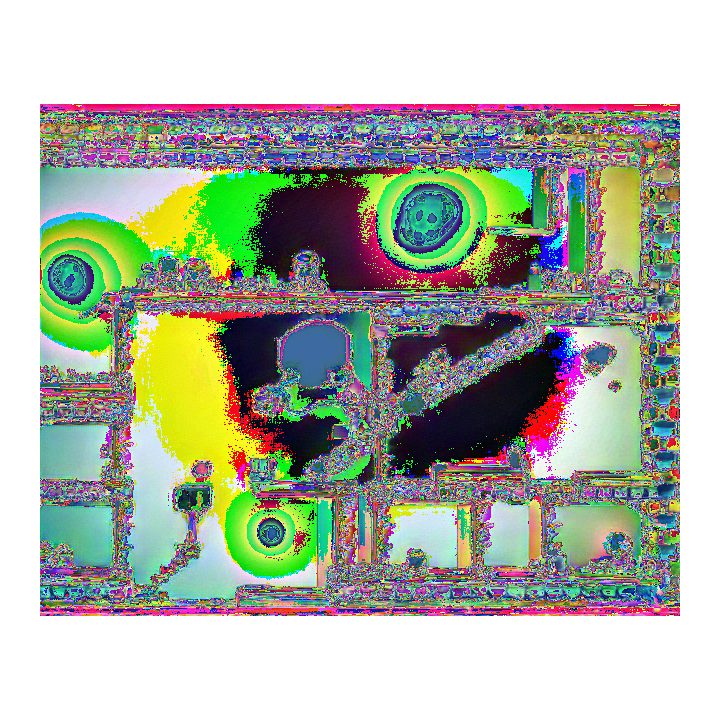

In [115]:
images_transformed, prompts_tokenized, prompts_tokenized_length = next(iter(demo_loader))
image_transformed = images_transformed[0]
prompt_tokenized = prompts_tokenized[0]
print("Encoded prompt:", prompt_tokenized.tolist())
transform_tensor_to_img = transforms.ToPILImage()
transform_tensor_to_img(image_transformed)

In [116]:
encoder = Encoder()
encoder.fine_tune(Parameters.fine_tune_encoder)
encoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, encoder.parameters()),
                                    lr=Parameters.encoder_lr) if Parameters.fine_tune_encoder else None

decoder = DecoderWithAttention(attention_dim=Parameters.attention_dim,
                                embed_dim=Parameters.emb_dim,
                                decoder_dim=Parameters.decoder_dim,
                                vocab_size=len(word_map_dict),
                                dropout=Parameters.dropout,
                                device=Parameters.device)
                                
decoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, decoder.parameters()),
                                    lr=Parameters.decoder_lr)

encoder, decoder, encoder_optimizer, decoder_optimizer, _, _, _ = load_checkpoint("resnet50_no-unk_15_no_stop", encoder, decoder, encoder_optimizer, decoder_optimizer, best=False)

### Encoding step

In [117]:
'''encoder = Encoder()
encoder.fine_tune(Parameters.fine_tune_encoder)
encoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, encoder.parameters()),
                                    lr=Parameters.encoder_lr) if Parameters.fine_tune_encoder else None
'''

'encoder = Encoder()\nencoder.fine_tune(Parameters.fine_tune_encoder)\nencoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, encoder.parameters()),\n                                    lr=Parameters.encoder_lr) if Parameters.fine_tune_encoder else None\n'

#### Image after encoding

Image shape before encoding: torch.Size([3, 720, 720])
Image shape after encoding: torch.Size([14, 14, 2048])


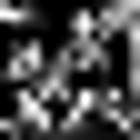

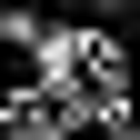

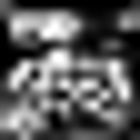

In [118]:
print("Image shape before encoding:", images_transformed[0].shape)

# Forward prop.
image_transformed_batch = encoder(images_transformed)
print("Image shape after encoding:", image_transformed_batch[0].shape)

convolutional_inputs_to_view = [15,69,420]
scale = 10

for conv_i in convolutional_inputs_to_view:
    conv_tensor = image_transformed_batch[0][:, :, conv_i]
    conv_img = transform_tensor_to_img(conv_tensor)
    
    display(conv_img.resize(( int(conv_img.width * scale), int(conv_img.height * scale))))


### Decoding step

In [119]:
'''
decoder = DecoderWithAttention(attention_dim=Parameters.attention_dim,
                                embed_dim=Parameters.emb_dim,
                                decoder_dim=Parameters.decoder_dim,
                                vocab_size=len(word_map_dict),
                                dropout=Parameters.dropout,
                                device=Parameters.device)
                                
decoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, decoder.parameters()),
                                    lr=Parameters.decoder_lr)
'''

'\ndecoder = DecoderWithAttention(attention_dim=Parameters.attention_dim,\n                                embed_dim=Parameters.emb_dim,\n                                decoder_dim=Parameters.decoder_dim,\n                                vocab_size=len(word_map_dict),\n                                dropout=Parameters.dropout,\n                                device=Parameters.device)\n                                \ndecoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, decoder.parameters()),\n                                    lr=Parameters.decoder_lr)\n'

In [120]:
scores, caps_sorted, decode_lengths, alphas, sort_ind = decoder(image_transformed_batch, prompts_tokenized, prompts_tokenized_length)

In [121]:
print(scores.shape)
scores = scores[:,:,:-1]

torch.Size([1, 9, 13925])


In [122]:
print("Words in sentence probabilities for prompt after decoding: \n")

"""sentence = []
for word_prob in scores[0]:
    best_word_encoded = torch.argmax(word_prob)
    word = list(word_map_dict.keys())[list(word_map_dict.values()).index(best_word_encoded)]
    sentence.append(word)"""
    

print(scores.shape)
print(torch.argmax(scores[0,:,:]))
print(scores)

" ".join([list(word_map_dict.keys())[list(word_map_dict.values()).index(torch.argmax(word_prob))] for word_prob in scores[0]])

Words in sentence probabilities for prompt after decoding: 

torch.Size([1, 9, 13924])
tensor(31467)
tensor([[[-1.9469, -1.8877, -0.6266,  ..., -2.0139, -4.9779, -3.8684],
         [-2.2835, -3.1189,  2.6246,  ..., -4.5258, -2.5581, -3.6185],
         [-2.4131, -4.4343,  3.8807,  ..., -5.4848, -2.8728, -4.1506],
         ...,
         [-2.0219, -4.2840,  4.2588,  ..., -4.5089, -2.8672, -4.3544],
         [-2.8260, -5.2516,  4.4228,  ..., -4.6094, -4.5326, -2.6304],
         [-3.2398, -5.0194,  4.4887,  ..., -5.1434, -4.8600, -3.3044]]],
       grad_fn=<SliceBackward0>)


'portrait of portrait of of art with with by'

In [123]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

In [124]:
sentence = []

for word_prob in scores[0]:
    best_word_encoded = torch.topk(word_prob, 2).indices
    for k in best_word_encoded:
        word_candidate = list(word_map_dict.keys())[list(word_map_dict.values()).index(k)]
        if word_candidate not in ["<pad>", "<start>", "<end>", "<unk>"] and word_candidate not in stop_words:
            if word_candidate not in sentence:
                sentence.append(word_candidate)
" ".join(sentence)

'portrait detailed renaissance art highly'

In [125]:
from tqdm import tqdm
beam_size = 1
device = 'cpu'
vocab_size = len(word_map_dict)
from random import randrange
import torch.nn.functional as F

In [133]:
for i, (image, caps, caplens) in enumerate(
        tqdm(demo_loader, desc="EVALUATING AT BEAM SIZE " + str(beam_size))):
        
        k = 5
        rand = 3

        imgs = image.to(Parameters.device)
        caps = caps.to(Parameters.device)
        caplens = caplens.to(Parameters.device)

        # Forward prop.
        encoder_out = encoder(imgs)
        encoder_dim = encoder_out.size(3)
        encoder_out = encoder_out.view(1, -1, encoder_dim)
        
        num_pixels = encoder_out.size(1)

        # We'll treat the problem as having a batch size of k
        encoder_out = encoder_out.expand(k, num_pixels, encoder_dim)

        k_prev_words = torch.LongTensor([[word_map_dict['<start>']]] * k).to(device)
        seqs = k_prev_words

        top_k_scores = torch.zeros(k, 1).to(device)  # (k, 1)

        # Lists to store completed sequences and scores
        complete_seqs = list()
        complete_seqs_scores = list()
        incomplete_inds = list()

        # Start decoding
        step = 1
        h, c = decoder.init_hidden_state(encoder_out)
        
        while True:
        
            embeddings = decoder.embedding(k_prev_words).squeeze(1)  # (s, embed_dim)

            awe, _ = decoder.attention(encoder_out, h)  # (s, encoder_dim), (s, num_pixels)

            gate = decoder.sigmoid(decoder.f_beta(h))  # gating scalar, (s, encoder_dim)
            
            h, c = decoder.decode_step(torch.cat([embeddings, awe], dim=-1), (h, c))  # (s, decoder_dim)

            scores = decoder.fc(h)
            scores = scores[:,:-1]
            scores = F.log_softmax(scores, dim=1)
            
            scores = top_k_scores.expand_as(scores) + scores
            '''
            all_new_beams = torch.empty(k*k, step+1)
            all_new_scores = torch.Tensor([])
            if step == 1:
                top_k_scores, top_k_words = scores[0].topk(k, 0, True, True)
            if step > 1:
                ind = 0
                for i in range(k):
                    tmp_seqs = [seqs[i].tolist()]*k
                    tmp_seqs = torch.Tensor(tmp_seqs)
                    top_k_scores, top_k_words = scores[i].topk(k, 0, True)
                    print("topk", top_k_scores)
                    tmp_seqs = torch.hstack([tmp_seqs, top_k_words.unsqueeze(1)])
                    all_new_beams[ind] = tmp_seqs
                    ind += 1
                    #all_new_scores = torch.vstack(all_new_scores, tmp_scores)
            
            print("new", all_new_beams)
            '''
            top_k_scores_list, top_k_words_list = list(), list()
            for i in range(k):
                if step == 1:
                    top_k_scores, top_k_words = scores[i].topk(rand, 0, True)  # (s)
                else:
                    # Unroll and find top scores, and their unrolled indices
                    top_k_scores, top_k_words = scores[i].topk(rand, 0, True)  

                indx = randrange(rand)
                
                top_k_scores_list.append(top_k_scores[indx])
                top_k_words_list.append(top_k_words[indx])
            
            top_k_words = torch.LongTensor(top_k_words_list)
            top_k_scores = torch.Tensor(top_k_scores_list)
            
            
            #prev_word_inds = prev_word_inds.long()
            prev_word_inds = top_k_words / vocab_size  # (s)
            next_word_inds = top_k_words % vocab_size  # (s)
            
            prev_word_inds = prev_word_inds.long()
            
            seqs = torch.hstack([seqs, next_word_inds.unsqueeze(1)])

        
            incomplete_inds = [ind for ind, next_word in enumerate(next_word_inds) if
                        next_word != word_map_dict['<end>']]
            
            
            complete_inds = list(set(range(len(next_word_inds))) - set(incomplete_inds))
            
            if len(complete_inds) > 0:
                complete_seqs.extend(seqs[complete_inds].tolist())
                complete_seqs_scores.extend(top_k_scores[complete_inds])
            k -= len(complete_inds)  # reduce beam length accordingly

            # Proceed with incomplete sequences
            if k == 0:
                break
            seqs = seqs[incomplete_inds]
            h = h[prev_word_inds[incomplete_inds]]
            c = c[prev_word_inds[incomplete_inds]]
            encoder_out = encoder_out[prev_word_inds[incomplete_inds]]
            top_k_scores = top_k_scores[incomplete_inds].unsqueeze(1)
            k_prev_words = next_word_inds[incomplete_inds].unsqueeze(1)

            # Break if things have been going on too long
            if step > 100:
                break
            step += 1
        
        print(complete_seqs_scores)
        joined = []
        for i in range(len(complete_seqs)):
           joined.append(" ".join([list(word_map_dict.keys())[list(word_map_dict.values()).index(ind)] for ind in complete_seqs[i]]))
        print(joined)
        
        

EVALUATING AT BEAM SIZE 1: 100%|██████████| 1/1 [00:03<00:00,  3.56s/it]

[tensor(-33.6728), tensor(-32.4781), tensor(-36.8736), tensor(-35.0184), tensor(-49.5322)]
['<start> highly of with with portrait of black with black of <end>', '<start> highly portrait with of portrait of black art of black <end>', '<start> an of with with portrait with with with with of art <end>', '<start> highly renaissance portrait portrait of of of art with of art <end>', '<start> portrait of with portrait with with black with black black black black art black art <end>']


In [ ]:
            '''  
            for i in range(k):
                if step == 1:
                    top_k_scores, top_k_words = scores[i].topk(1, 0, True)  # (s)
                else:
                    # Unroll and find top scores, and their unrolled indices
                    top_k_scores, top_k_words = scores[i].topk(1, 0, True)  

                indx = randrange(1)
                
                top_k_scores_list.append(top_k_scores[indx])
                top_k_words_list.append(top_k_words[indx])
            
            top_k_words = torch.LongTensor(top_k_words_list)
            top_k_scores = torch.Tensor(top_k_scores_list)
            '''

In [ ]:
from tqdm import tqdm
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
from datasets import *
from utils import *
from nltk.translate.bleu_score import corpus_bleu
import torch.nn.functional as F
"""
Evaluation
:param beam_size: beam size at which to generate captions for evaluation
:return: BLEU-4 score
"""

beam_size = 1
device = "cpu"
vocab_size = len(word_map_dict)

# TODO: Batched Beam Search
# Therefore, do not use a batch_size greater than 1 - IMPORTANT!

# Lists to store references (true captions), and hypothesis (prediction) for each image
# If for n images, we have n hypotheses, and references a, b, c... for each image, we need -
# references = [[ref1a, ref1b, ref1c], [ref2a, ref2b], ...], hypotheses = [hyp1, hyp2, ...]
references = list()
hypotheses = list()

# For each image
for i, (image, caps, caplens) in enumerate(
        tqdm(demo_loader, desc="EVALUATING AT BEAM SIZE " + str(beam_size))):

    k = beam_size

    # Move to GPU device, if available
    image = image.to(device)  # (1, 3, 256, 256)

    # Encode
    encoder_out = encoder(image)  # (1, enc_image_size, enc_image_size, encoder_dim)
    enc_image_size = encoder_out.size(1)
    encoder_dim = encoder_out.size(3)

    # Flatten encoding
    encoder_out = encoder_out.view(1, -1, encoder_dim)  # (1, num_pixels, encoder_dim)
    num_pixels = encoder_out.size(1)

    # We'll treat the problem as having a batch size of k
    encoder_out = encoder_out.expand(k, num_pixels, encoder_dim)  # (k, num_pixels, encoder_dim)

    # Tensor to store top k previous words at each step; now they're just <start>
    k_prev_words = torch.LongTensor([[word_map_dict['<start>']]] * k).to(device)  # (k, 1)

    # Tensor to store top k sequences; now they're just <start>
    seqs = k_prev_words  # (k, 1)

    # Tensor to store top k sequences' scores; now they're just 0
    top_k_scores = torch.zeros(k, 1).to(device)  # (k, 1)

    # Lists to store completed sequences and scores
    complete_seqs = list()
    complete_seqs_scores = list()

    # Start decoding
    step = 1
    h, c = decoder.init_hidden_state(encoder_out)

    # s is a number less than or equal to k, because sequences are removed from this process once they hit <end>
    while True:

        embeddings = decoder.embedding(k_prev_words).squeeze(1)  # (s, embed_dim)

        awe, _ = decoder.attention(encoder_out, h)  # (s, encoder_dim), (s, num_pixels)

        gate = decoder.sigmoid(decoder.f_beta(h))  # gating scalar, (s, encoder_dim)
        awe = gate * awe

        h, c = decoder.decode_step(torch.cat([embeddings, awe], dim=1), (h, c))  # (s, decoder_dim)

        scores = decoder.fc(h)  # (s, vocab_size)
        scores = scores[:,:-1]
        scores = F.log_softmax(scores, dim=1)

        # Add
        scores = top_k_scores.expand_as(scores) + scores  # (s, vocab_size)

        # For the first step, all k points will have the same scores (since same k previous words, h, c)
        if step == 1:
            top_k_scores, top_k_words = scores[0].topk(k, 0, True, False)  # (s)
        else:
            # Unroll and find top scores, and their unrolled indices
            top_k_scores, top_k_words = scores.view(-1).topk(k, 0, True, False)  # (s)

        # Convert unrolled indices to actual indices of scores
        prev_word_inds = top_k_words / vocab_size  # (s)
        next_word_inds = top_k_words % vocab_size  # (s)
        
        prev_word_inds = prev_word_inds.long()
        
        # Add new words to sequences
        seqs = torch.cat([seqs[prev_word_inds], next_word_inds.unsqueeze(1)], dim=1)  # (s, step+1)

        # Which sequences are incomplete (didn't reach <end>)?
        incomplete_inds = [ind for ind, next_word in enumerate(next_word_inds) if
                            next_word != word_map_dict['<end>']]
        
        complete_inds = list(set(range(len(next_word_inds))) - set(incomplete_inds))

        # Set aside complete sequences
        if len(complete_inds) > 0:
            complete_seqs.extend(seqs[complete_inds].tolist())
            complete_seqs_scores.extend(top_k_scores[complete_inds])
        k -= len(complete_inds)  # reduce beam length accordingly

        # Proceed with incomplete sequences
        if k == 0:
            break
        seqs = seqs[incomplete_inds]
        h = h[prev_word_inds[incomplete_inds]]
        c = c[prev_word_inds[incomplete_inds]]
        encoder_out = encoder_out[prev_word_inds[incomplete_inds]]
        top_k_scores = top_k_scores[incomplete_inds].unsqueeze(1)
        k_prev_words = next_word_inds[incomplete_inds].unsqueeze(1)

        # Break if things have been going on too long
        if step > 100:
            break
        step += 1

    i = complete_seqs_scores.index(max(complete_seqs_scores))
    seq = complete_seqs[i]

    # References
    img_captions = list(
        map(lambda c: [w for w in c if w not in {word_map_dict['<start>'], word_map_dict['<pad>']}],
            caps))  # remove <start> and pads
    references.append(img_captions)

    # Hypotheses
    hypotheses.append([w for w in seq if w not in {word_map_dict['<start>'], word_map_dict['<end>'], word_map_dict['<pad>']}])

    assert len(references) == len(hypotheses)

# Calculate BLEU-4 scores
bleu4 = corpus_bleu(references, hypotheses)

print(hypotheses)



beam_size = 1
print("\nBLEU-4 score @ beam size of %d is %.4f." % (beam_size, bleu4))

EVALUATING AT BEAM SIZE 1: 100%|██████████| 1/1 [00:02<00:00,  2.66s/it]

[[3619, 18, 18, 18, 18, 18, 18]]

BLEU-4 score @ beam size of 1 is 0.0000.


In [ ]:
hypotheses

[[3619, 18, 18, 18, 18, 18, 18]]

In [ ]:
import numpy as np
values, indices = scores.sort(-1)

In [ ]:
indices

tensor([[12013,  7925,  8781,  ...,   115,    29,     2]])